<a href="https://colab.research.google.com/github/ahmedelalaoui142/Forecasting_financial_time_series/blob/main/INTERNSHIP5_predicting_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Optional: Set random seeds for reproducibility
import tensorflow as tf
import random
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [ ]:
# Define start and end dates
start_date = '2014-01-01'
end_date = '2024-09-01'  # Adjusted to the latest available date if necessary

# Download Microsoft stock data
df = yf.download('MSFT', start=start_date, end=end_date)
df.sort_index(inplace=True)

# Use only the 'Close' column
data = df[['Close']]


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Assuming 'data' contains data up to '2024-09-01'

# Define the cutoff date for the last two months
# If 'data' doesn't have data up to '2024-09-01', this will adjust to the latest available date
last_date = data.index[-1]
cutoff_date = last_date - pd.DateOffset(months=2)

# Split data into training and future (testing) sets
train_data = data[data.index <= cutoff_date]
future_data = data[data.index > cutoff_date]

print(f"Training data end date: {train_data.index[-1].date()}")
print(f"Future data start date: {future_data.index[0].date()}")


Training data end date: 2024-06-28
Future data start date: 2024-07-01


In [ ]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)


In [ ]:
# Define the lookback period
lookback = 90

# Function to create sequences
def create_sequences(dataset, lookback):
    X, Y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Create sequences from the scaled training data
X_train, y_train = create_sequences(scaled_train_data, lookback)

# Reshape X_train to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (2550, 90, 1)
y_train shape: (2550,)


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(units=150))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0126
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.7055e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7230e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4986e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.4228e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1786e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9631e-04
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.9044e-04
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.8613e-04
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8267e-04
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7816e-04
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7233e-04
Epoch 13/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6551e-04
Epoch 14/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5804e-04

In [ ]:
# Number of days to predict (number of entries in future_data)
future_days = len(future_data)

# Get the last lookback days from the training data
last_sequence = scaled_train_data[-lookback:]


In [ ]:
# Initialize a list to store predictions
future_predictions = []

# Predict future prices
for _ in range(future_days):
    # Prepare the input data
    input_seq = np.reshape(last_sequence, (1, lookback, 1))
    # Make the prediction
    next_pred = model.predict(input_seq)
    # Reshape next_pred to have shape (1, 1)
    next_pred = next_pred.reshape(-1, 1)
    # Append the prediction
    future_predictions.append(next_pred[0, 0])
    # Update the last_sequence by appending the prediction and removing the first element
    last_sequence = np.concatenate((last_sequence[1:], next_pred), axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [ ]:
# Inverse transform the predictions
future_predictions = np.array(future_predictions)
future_predictions = future_predictions.reshape(-1, 1)
future_predictions_inv = scaler.inverse_transform(future_predictions)

In [ ]:
actual_prices = future_data['Close'].values

In [ ]:
rmse = np.sqrt(mean_squared_error(actual_prices, future_predictions_inv))
mape = mean_absolute_percentage_error(actual_prices, future_predictions_inv)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.4f}')

RMSE: 16.80
MAPE: 0.0341


In [ ]:
future_dates = future_data.index
predicted_prices = future_predictions_inv.flatten()

comparison_df = pd.DataFrame({
    'Date': future_dates,
    'Actual': actual_prices,
    'Predicted': predicted_prices
})

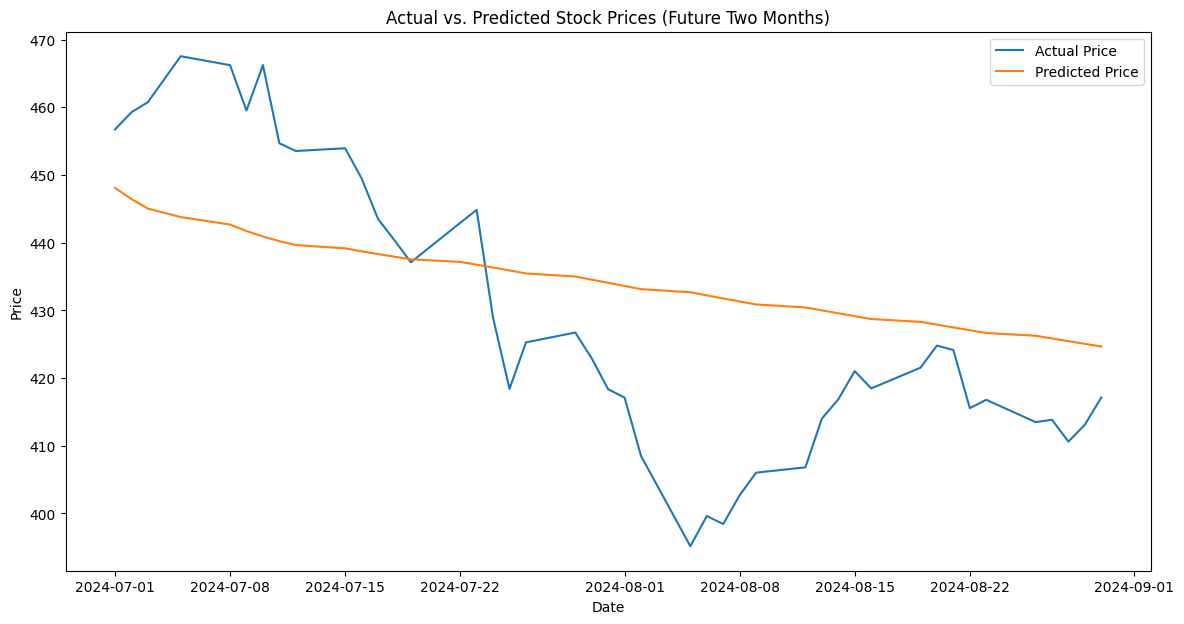

In [ ]:

# Plot the actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Price')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Price')
plt.title('Actual vs. Predicted Stock Prices (Future Two Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()